In [1]:
!pip install transformers accelerate torch pandas numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [62]:
from transformers import AutoModel, AutoTokenizer, BertConfig, BertForSequenceClassification
import torch.nn as nn

backbone_name = "DeepPavlov/distilrubert-tiny-cased-conversational"

config = BertConfig.from_pretrained(
    backbone_name,
    num_labels=3,
    hidden_dropout_prob=0.1,
)

model = BertForSequenceClassification.from_pretrained(
    backbone_name,
    config=config
)

tokenizer = AutoTokenizer.from_pretrained(backbone_name)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bi

In [63]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [64]:
import torch

for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split

dataset = pd.read_csv("/content/russian_text_classification_dataset.csv")

In [66]:
dataset.head()

,text,label
0,Пёс охранял мой велосипед.,1
1,Сплю в зимней куртке — нет отопления.,2
2,Проверил давление в шинах.,0
3,Пса покусал клещ.,1
4,Погладил одежду перед работой.,0


In [67]:
from torch.utils.data import Dataset

class RusDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_len=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        text = self.df.loc[idx, "text"]
        label = self.df.loc[idx, "label"]

        encoded = self.tokenizer(
            text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_len
        )
        input_ids = encoded["input_ids"].squeeze(0)
        attention_mask=encoded["attention_mask"].squeeze(0)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label, dtype=torch.long)
        }

data = RusDataset(dataset, tokenizer)

In [68]:
from torch.utils.data import DataLoader

train, test = train_test_split(data, test_size=0.3)
eval, test = train_test_split(test, test_size=0.5)

train_dataloader = DataLoader(dataset=train, batch_size=4)
eval_dataloader = DataLoader(eval, batch_size=8)
test_dataloader = DataLoader(test, batch_size=8)

In [69]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.metrics import f1_score

optim = Adam(params=model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

num_epochs = 50

best_model_path = "best_model.pt"
best_f1 = 0.0

track_train_loss = []
track_eval_loss = []
track_f1 = []

for epoch in range(1, num_epochs + 1):
    model.train()
    training_loss = 0.0
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label = batch["label"].to(device)

        optim.zero_grad()

        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[0]

        loss = criterion(output, label)

        training_loss += loss.item()

        loss.backward()
        optim.step()
    avg_tr_loss = training_loss / len(train_dataloader)
    print(f"Epoch - {epoch} Training Loss = {avg_tr_loss: .6f}")

    model.eval()
    eval_loss = 0.0
    all_preds, all_labels = [], []
    for batch in eval_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label = batch["label"].to(device)

        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[0]

        loss = criterion(output, label)
        eval_loss += loss.item()

        predictions = torch.argmax(output, dim=1)
        all_preds.extend(predictions.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

    avg_eval_loss = eval_loss / len(eval_dataloader)
    F1_eval = f1_score(all_labels, all_preds, average="macro")
    print(f"Epoch - {epoch} Evaluation Loss = {avg_eval_loss: .6f} F1 Macro = {F1_eval: .4f}")

    track_train_loss.append(avg_tr_loss)
    track_eval_loss.append(avg_eval_loss)
    track_f1.append(F1_eval)

    if F1_eval > best_f1:
        best_f1 = F1_eval
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved at epoch {epoch}")
    print()

model.load_state_dict(torch.load(best_model_path, map_location=device))

Epoch - 1 Training Loss =  1.163151
Epoch - 1 Evaluation Loss =  1.077165 F1 Macro =  0.3263
New best model saved at epoch 1

Epoch - 2 Training Loss =  1.121090
Epoch - 2 Evaluation Loss =  1.051178 F1 Macro =  0.5772
New best model saved at epoch 2

Epoch - 3 Training Loss =  1.099364
Epoch - 3 Evaluation Loss =  1.041721 F1 Macro =  0.4243

Epoch - 4 Training Loss =  1.088251
Epoch - 4 Evaluation Loss =  1.007700 F1 Macro =  0.4854

Epoch - 5 Training Loss =  1.061858
Epoch - 5 Evaluation Loss =  0.978387 F1 Macro =  0.5635

Epoch - 6 Training Loss =  1.055029
Epoch - 6 Evaluation Loss =  0.955583 F1 Macro =  0.6500
New best model saved at epoch 6

Epoch - 7 Training Loss =  1.025873
Epoch - 7 Evaluation Loss =  0.945825 F1 Macro =  0.6272

Epoch - 8 Training Loss =  1.035345
Epoch - 8 Evaluation Loss =  0.938243 F1 Macro =  0.6017

Epoch - 9 Training Loss =  1.007962
Epoch - 9 Evaluation Loss =  0.924372 F1 Macro =  0.6193

Epoch - 10 Training Loss =  1.024517
Epoch - 10 Evaluation

<All keys matched successfully>

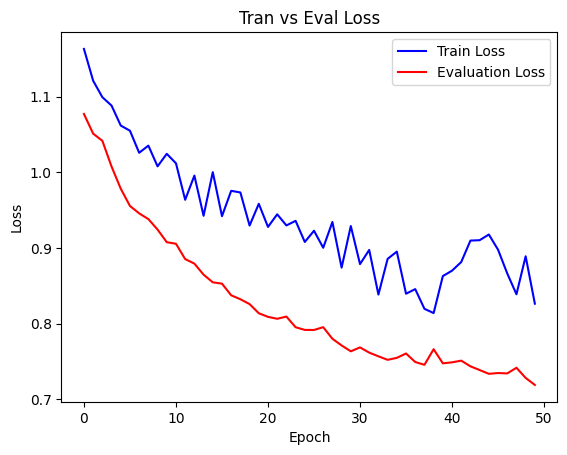

In [76]:
import matplotlib.pyplot as plt

plt.plot(track_train_loss, color="blue", label="Train Loss")
plt.plot(track_eval_loss, color="red", label="Evaluation Loss")
plt.title("Tran vs Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

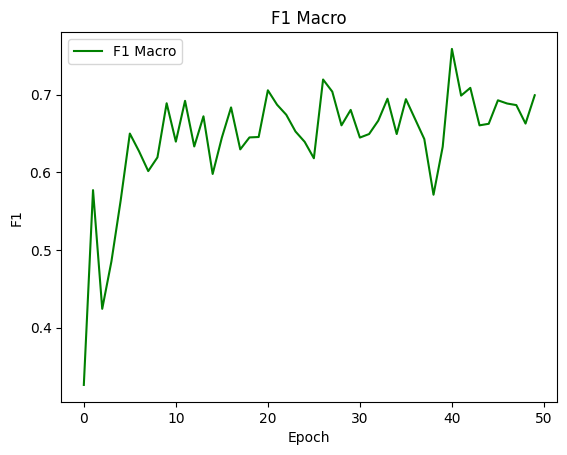

In [78]:
plt.plot(track_f1, color="green", label="F1 Macro")
plt.title("F1 Macro")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()
plt.show()

In [70]:
from sklearn.metrics import f1_score
import torch

model.to(device)
model.eval()
test_loss = 0.0
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label = batch["label"].to(device)

        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[0]

        loss = criterion(output, label)

        test_loss += loss.item()
        predicted_labels = torch.argmax(output, dim=1)

        all_preds.extend(predicted_labels.cpu().numpy().tolist())
        all_labels.extend(label.cpu().numpy().tolist())

avg_test_loss = test_loss / len(test_dataloader)
F1 = f1_score(y_true=all_labels, y_pred=all_preds, average="macro")
print(f"Test Loss = {avg_test_loss: .6f} F1 MACRO = {F1: .4f}")

Test Loss =  0.757006 F1 MACRO =  0.7946


In [79]:
save_path = "classification_model"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("Success")

Success
